In [90]:
import tools, timeit, os
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from urllib.parse import urlencode
%config InlineBackend.rc = {}
%matplotlib inline

In [296]:
# Constants
DIR_DATA = '../data/PTF/'
MAX_DOWNLOADS = 5

In [297]:
# URLs
CATALOG_API = 'http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query'
CALI_IMAGES_CATALOG_API = 'http://irsa.ipac.caltech.edu/ibe/search/ptf/images/level1'
CALI_IMAGES_API = 'http://irsa.ipac.caltech.edu/ibe/data/ptf/images/level1'
REF_IMAGES_CATALOG_API = 'http://irsa.ipac.caltech.edu/ibe/search/ptf/images/level2'
REF_IMAGES_API = 'http://irsa.ipac.caltech.edu/ibe/data/ptf/images/level2'

# Download 20000 Transients

#### Create request

In [99]:
query = dict()
query['catalog'] = 'ptf_objects'
query['spatial'] = 'None'
query['selcols'] = 'ra,dec,oid,nobs,ngoodobs'
query['outfmt'] = '1'
query['outrows'] = '20000'
query['constraints'] = 'transient_flag=1 AND nobs >= 20 AND ngoodobs>= 15'

query_url = CATALOG_API + '?' + urlencode(query)
print(query_url)

http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query?spatial=None&outfmt=1&selcols=ra%2Cdec%2Coid%2Cnobs%2Cngoodobs&catalog=ptf_objects&constraints=transient_flag%3D1+AND+nobs+%3E%3D+20+AND+ngoodobs%3E%3D+15&outrows=20000


#### Download data

In [ ]:
output_directory = DIR_DATA + 'cats/transients'
file_path = tools.download_file(query_url, 'objcat.tbl', output_directory)

In [101]:
file_path

'../data/PTF/cats/transients/objcat.tbl'

### Read catalogue

In [102]:
transient_df = Table.read(file_path, format='ascii').to_pandas()

In [103]:
transient_df.head()

,ra,dec,clon,clat,oid,nobs,ngoodobs
0,291.823749,45.201545,19h27m17.70s,45d12m05.56s,46572075001313,161,160
1,291.808502,45.210343,19h27m14.04s,45d12m37.23s,46572075001316,254,74
2,291.837458,45.231821,19h27m20.99s,45d13m54.56s,46572075001274,232,48
3,291.848750,45.202769,19h27m23.70s,45d12m09.97s,46572075001312,188,187
4,291.805963,45.177574,19h27m13.43s,45d10m39.27s,46572075002105,128,35


# Download R light curves

In [104]:
output_directory = DIR_DATA + 'light/R/'

#### Create request

In [129]:
def light_url(ra, dec):
    query = dict()
    query['catalog'] = 'ptf_lightcurves'
    query['spatial'] = 'None'
    query['selcols'] = 'oid,obsmjd,mag_autocorr'
    query['outfmt'] = '1'
    query['constraints'] = 'ra={} AND dec={} AND fid=2 AND goodflag=1'.format(ra, dec)
    query['order'] = 'obsmjd'
    
    query_url = CATALOG_API + '?' + urlencode(query)
    return query_url

#### Download Files

In [ ]:
for i, row in transient_df.iterrows():
    if i == MAX_DOWNLOADS: break
    objid = row['oid']
    query_url = light_url(row['ra'], row['dec'])
    file_path = tools.download_file(query_url, '{}.tbl'.format(objid), output_directory)

# Download Calibrated Images 

### First, download the calibrated image catalogues

In [298]:
output_directory = DIR_DATA + 'cats/calibrated/'

#### Create request

In [299]:
def calibrated_catalog_url(ra, dec):
    query = dict()
    # Available Columns: 
    # http://irsa.ipac.caltech.edu/ibe//search/ptf/images/level1?FORMAT=METADATA&ct=html
    query['POS'] = '{},{}'.format(ra,dec)
    query['columns'] = 'pfilename,obsdate'
    query['where'] = 'filter=\'R\''
    # Only querying for the most centered image data
    query['mcen'] = '1'
    
    query_url = CALI_IMAGES_CATALOG_API + '?' + urlencode(query)
    return query_url

#### Download

In [300]:
for i, row in transient_df.iterrows():
    if i == MAX_DOWNLOADS: break
    objid = row['oid']
    query_url = calibrated_catalog_url(row['ra'], row['dec'])
    file_path = tools.download_file(query_url, '{}.tbl'.format(objid), output_directory)

read 0
read 8192
read 0
read 8192
read 0
read 8192
read 0
read 8192
read 0
read 8192


### Next, download the associated images

In [301]:
output_directory = DIR_DATA + 'images/calibrated/'
IMAGE_SIZE = (50,50) # arcsec

In [302]:
def calibrated_image_url(ra, dec, image_url_path, size):
    query = dict()
    # Available Columns: 
    query['center'] = '{},{}'.format(ra, dec)
    query['size'] = '{},{}arcsec'.format(size[0], size[1])
    query_url = CALI_IMAGES_API + '/' + image_url_path + '?' + urlencode(query)
    return query_url

In [303]:
for i, row in transient_df.iterrows():
    if i == MAX_DOWNLOADS: break
    calibrated_catalog_path = DIR_DATA + 'cats/calibrated/{}.tbl'.format(row['oid'])
    calibrated_df = Table.read(calibrated_catalog_path, format='ascii').to_pandas()
    query_url = calibrated_image_url(row['ra'], row['dec'], calibrated_df.iloc[0]['pfilename'], IMAGE_SIZE)
    print(query_url)
    file_path = tools.download_file(query_url, '{}.fits'.format(row['oid']), output_directory)

http://irsa.ipac.caltech.edu/ibe/data/ptf/images/level1/proc/2011/07/21/f2/c7/p13/v2/PTF_201107213814_i_p_scie_t090910_u010278159_f02_p004657_c07.fits?size=50%2C50arcsec&center=291.823749%2C45.201545


138.4% 24576 / 17751


http://irsa.ipac.caltech.edu/ibe/data/ptf/images/level1/proc/2011/07/21/f2/c7/p13/v2/PTF_201107213814_i_p_scie_t090910_u010278159_f02_p004657_c07.fits?size=50%2C50arcsec&center=291.808502%2C45.210343


136.6% 24576 / 17995


http://irsa.ipac.caltech.edu/ibe/data/ptf/images/level1/proc/2011/07/21/f2/c7/p13/v2/PTF_201107213814_i_p_scie_t090910_u010278159_f02_p004657_c07.fits?size=50%2C50arcsec&center=291.837458%2C45.231821


137.0% 24576 / 17933


http://irsa.ipac.caltech.edu/ibe/data/ptf/images/level1/proc/2011/07/21/f2/c7/p13/v2/PTF_201107213814_i_p_scie_t090910_u010278159_f02_p004657_c07.fits?size=50%2C50arcsec&center=291.84875%2C45.202769


137.2% 24576 / 17910


http://irsa.ipac.caltech.edu/ibe/data/ptf/images/level1/proc/2011/07/21/f2/c7/p13/v2/PTF_201107213814_i_p_scie_t090910_u010278159_f02_p004657_c07.fits?size=50%2C50arcsec&center=291.805963%2C45.177574


136.9% 24576 / 17951


# Download Reference Images 

### First, download the reference image catalogues

In [304]:
output_directory = DIR_DATA + 'cats/reference/'

#### Create request

In [305]:
def reference_catalog_url(ra, dec):
    query = dict()
    # Available Columns: 
    # http://irsa.ipac.caltech.edu/ibe//search/ptf/images/level1?FORMAT=METADATA&ct=html
    query['POS'] = '{},{}'.format(ra,dec)
    query['columns'] = 'filename'
    query['where'] = 'fid=2'
    # Only querying for the most centered image data
    query['mcen'] = '1'
    
    query_url = REF_IMAGES_CATALOG_API + '?' + urlencode(query)
    return query_url

#### Download

In [306]:
for i, row in transient_df.iterrows():
    if i == MAX_DOWNLOADS: break
    query_url = reference_catalog_url(row['ra'], row['dec'])
    print(query_url)
    file_path = tools.download_file(query_url, '{}.tbl'.format(row['oid']), output_directory)

http://irsa.ipac.caltech.edu/ibe/search/ptf/images/level2?POS=291.823749%2C45.201545&where=fid%3D2&mcen=1&columns=filename


read 0
read 8192


http://irsa.ipac.caltech.edu/ibe/search/ptf/images/level2?POS=291.808502%2C45.210343&where=fid%3D2&mcen=1&columns=filename


read 0
read 8192


http://irsa.ipac.caltech.edu/ibe/search/ptf/images/level2?POS=291.837458%2C45.231821&where=fid%3D2&mcen=1&columns=filename


read 0
read 8192


http://irsa.ipac.caltech.edu/ibe/search/ptf/images/level2?POS=291.84875%2C45.202769&where=fid%3D2&mcen=1&columns=filename


read 0
read 8192


http://irsa.ipac.caltech.edu/ibe/search/ptf/images/level2?POS=291.805963%2C45.177574&where=fid%3D2&mcen=1&columns=filename


read 0
read 8192


### Next, download the associated images

In [307]:
output_directory = DIR_DATA + 'images/reference/'

##### Full reference image paths are hidden, so they need to be extracted from filename

In [308]:
def extract_ref_image_path(filename):
    words = filename.split('_')
    f1 = words[1][:4]
    f2 = words[1]
    f3 = words[2][0] + words[2][1:].lstrip('0')
    if len(f3) == 1: f3 += '0'
    f4 = words[3][0] + words[3][1:].lstrip('0')
    if len(f4) == 1: f4 += '0'
    return '{}/{}/{}/{}/{}'.format(f1,f2,f3,f4,filename)

In [309]:
def reference_image_url(ra, dec, image_url_path, size):
    query = dict()
    # Available Columns: 
    query['center'] = '{},{}'.format(ra, dec)
    query['size'] = '{},{}arcsec'.format(size[0], size[1])
    query_url = REF_IMAGES_API + '/' + image_url_path + '?' + urlencode(query)
    return query_url

#### Download

In [310]:
for i, row in transient_df.iterrows():
    if i == MAX_DOWNLOADS: break
    reference_catalog_path = DIR_DATA + 'cats/reference/{}.tbl'.format(row['oid'])
    reference_df = Table.read(reference_catalog_path, format='ascii').to_pandas()
    ref_image_path = extract_ref_image_path(reference_df.iloc[0]['filename'])
    query_url = reference_image_url(row['ra'], row['dec'], ref_image_path, IMAGE_SIZE)
    file_path = tools.download_file(query_url, '{}.fits'.format(row['oid']), output_directory)

104.9% 106496 / 101563
104.5% 106496 / 101896
103.5% 106496 / 102915
105.1% 106496 / 101359
105.0% 106496 / 101449


# Display images difference 

####  Normalize image

In [311]:
def normalize_image(img):
    img = np.nan_to_num(img)
    img = img/np.std(img)
    return img

In [312]:
def resized_matrices(m1, m2):
    m1x, m1y = m1.shape
    m2x, m2y = m2.shape
    
    if m1x > m2x: m1 = m1[:m2x, :]
    if m2x > m1x: m2 = m2[:m1x, :]
        
    if m1y > m2y: m1 = m1[:, :m2y]
    if m2y > m1y: m2 = m2[:, :m1y]
    
    return m1,m2

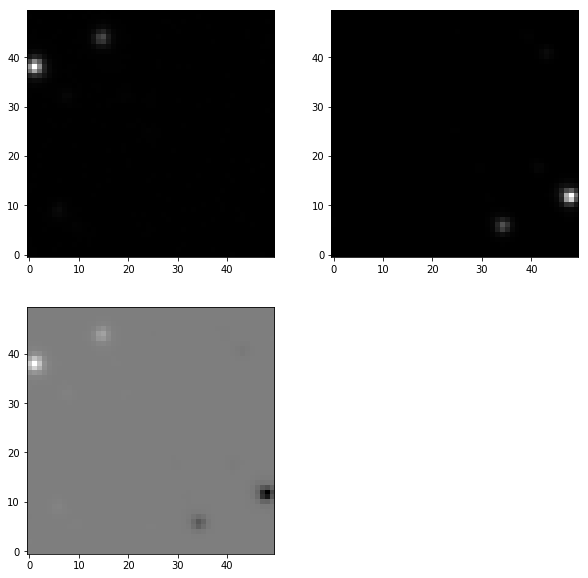

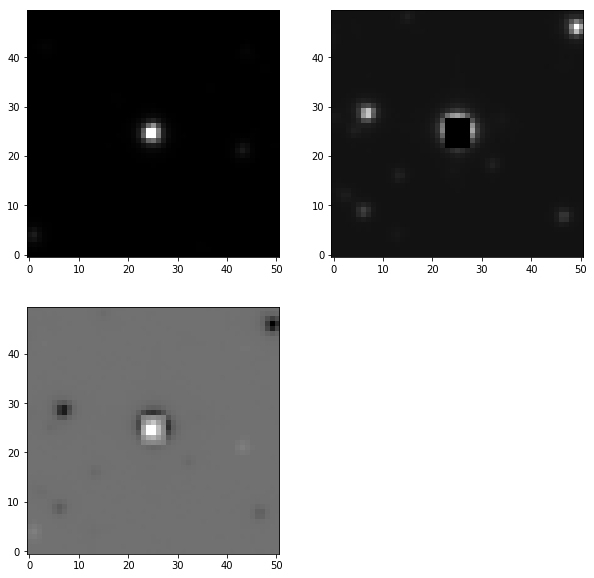

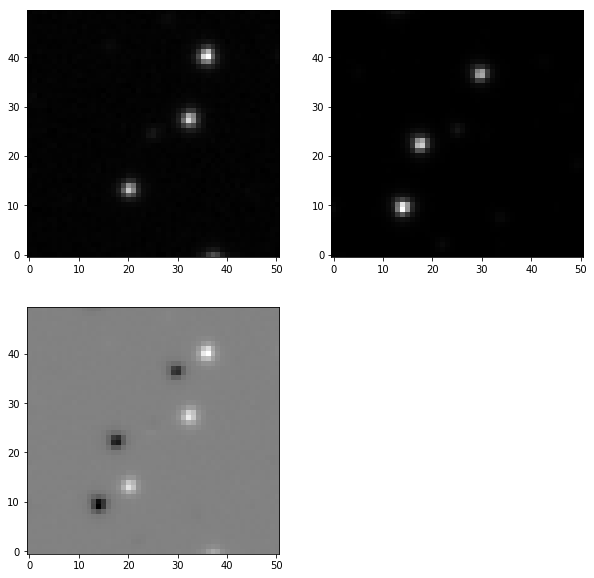

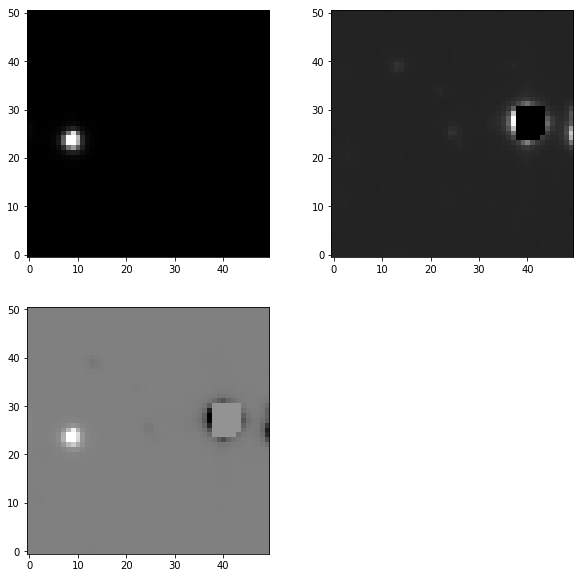

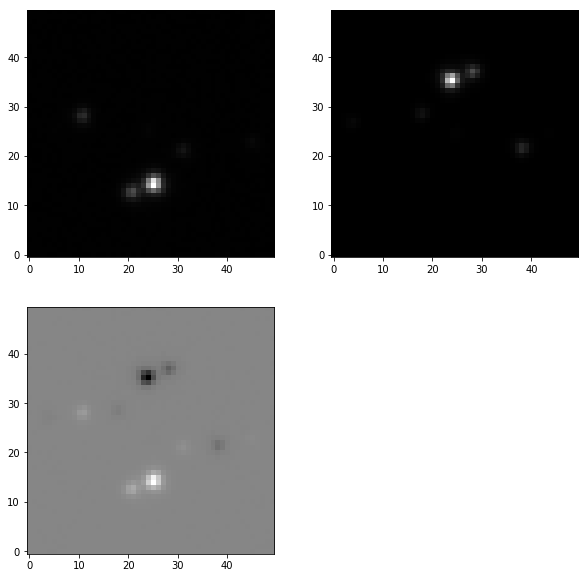

In [313]:
for i, row in transient_df.iterrows():
    if i == MAX_DOWNLOADS: break
        
    # Retrieve data
    scientific_image_path = DIR_DATA + 'images/calibrated/{}.fits'.format(row['oid'])
    reference_image_path = DIR_DATA + 'images/reference/{}.fits'.format(row['oid'])
    scientific_image = normalize_image(fits.getdata(scientific_image_path))
    reference_image = normalize_image(fits.getdata(reference_image_path))
    scientific_image, reference_image = resized_matrices(scientific_image, reference_image)
    diff_image = scientific_image - reference_image
                   
    # Present
    fig = plt.figure(figsize=(10,10))
    ax1 = plt.subplot('221')
    ax1.imshow(scientific_image, origin='lower', cmap='gray')
    ax2 = plt.subplot('222')
    ax2.imshow(reference_image, origin='lower', cmap='gray')
    ax3 = plt.subplot('223')
    ax3.imshow(diff_image, origin='lower', cmap='gray')